# Predição do **churn**

Este é o arquivo principal que roda todo a pipeline para a predição do **churn** utilizando o dataset em "*Abandono_clientes.csv*" para treinamento e o dataset de teste deve possuir a mesma estrutura do arquivo "*Abandono_teste.csv*" para funcionar.

### 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

### 2. Read .csv file and preprocess data

In [2]:
df_original = pd.read_csv('Abandono_clientes.csv')

In [3]:
def drop_irrelevant(df):
    df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
    df = df.dropna()  # drop missing values
    return df

def encode_categorical(df):
    df = pd.get_dummies(df, columns=['Gender'], drop_first=True)
    df = pd.get_dummies(df, columns=['Geography'], drop_first=False)
    return df

In [4]:
df = drop_irrelevant(df_original)
df = encode_categorical(df)

# Normalize numerical features
scaler = StandardScaler()
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

### 3. Show data info

In [5]:
df.info()  # Shows data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  float64
 1   Age                10000 non-null  float64
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  float64
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Gender_Male        10000 non-null  bool   
 10  Geography_France   10000 non-null  bool   
 11  Geography_Germany  10000 non-null  bool   
 12  Geography_Spain    10000 non-null  bool   
dtypes: bool(4), float64(6), int64(3)
memory usage: 742.3 KB


In [6]:
df.head()  # First few rows to understand the structure

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_France,Geography_Germany,Geography_Spain
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,1,1,0.021886,1,False,True,False,False
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,0,1,0.216534,0,False,False,False,True
2,-1.536794,0.293517,1.032908,1.333053,2.527057,1,0,0.240687,1,False,True,False,False
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,0,0,-0.108918,0,False,True,False,False
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,1,1,-0.365276,0,False,False,False,True


##### 3.1. Correlation

<Axes: >

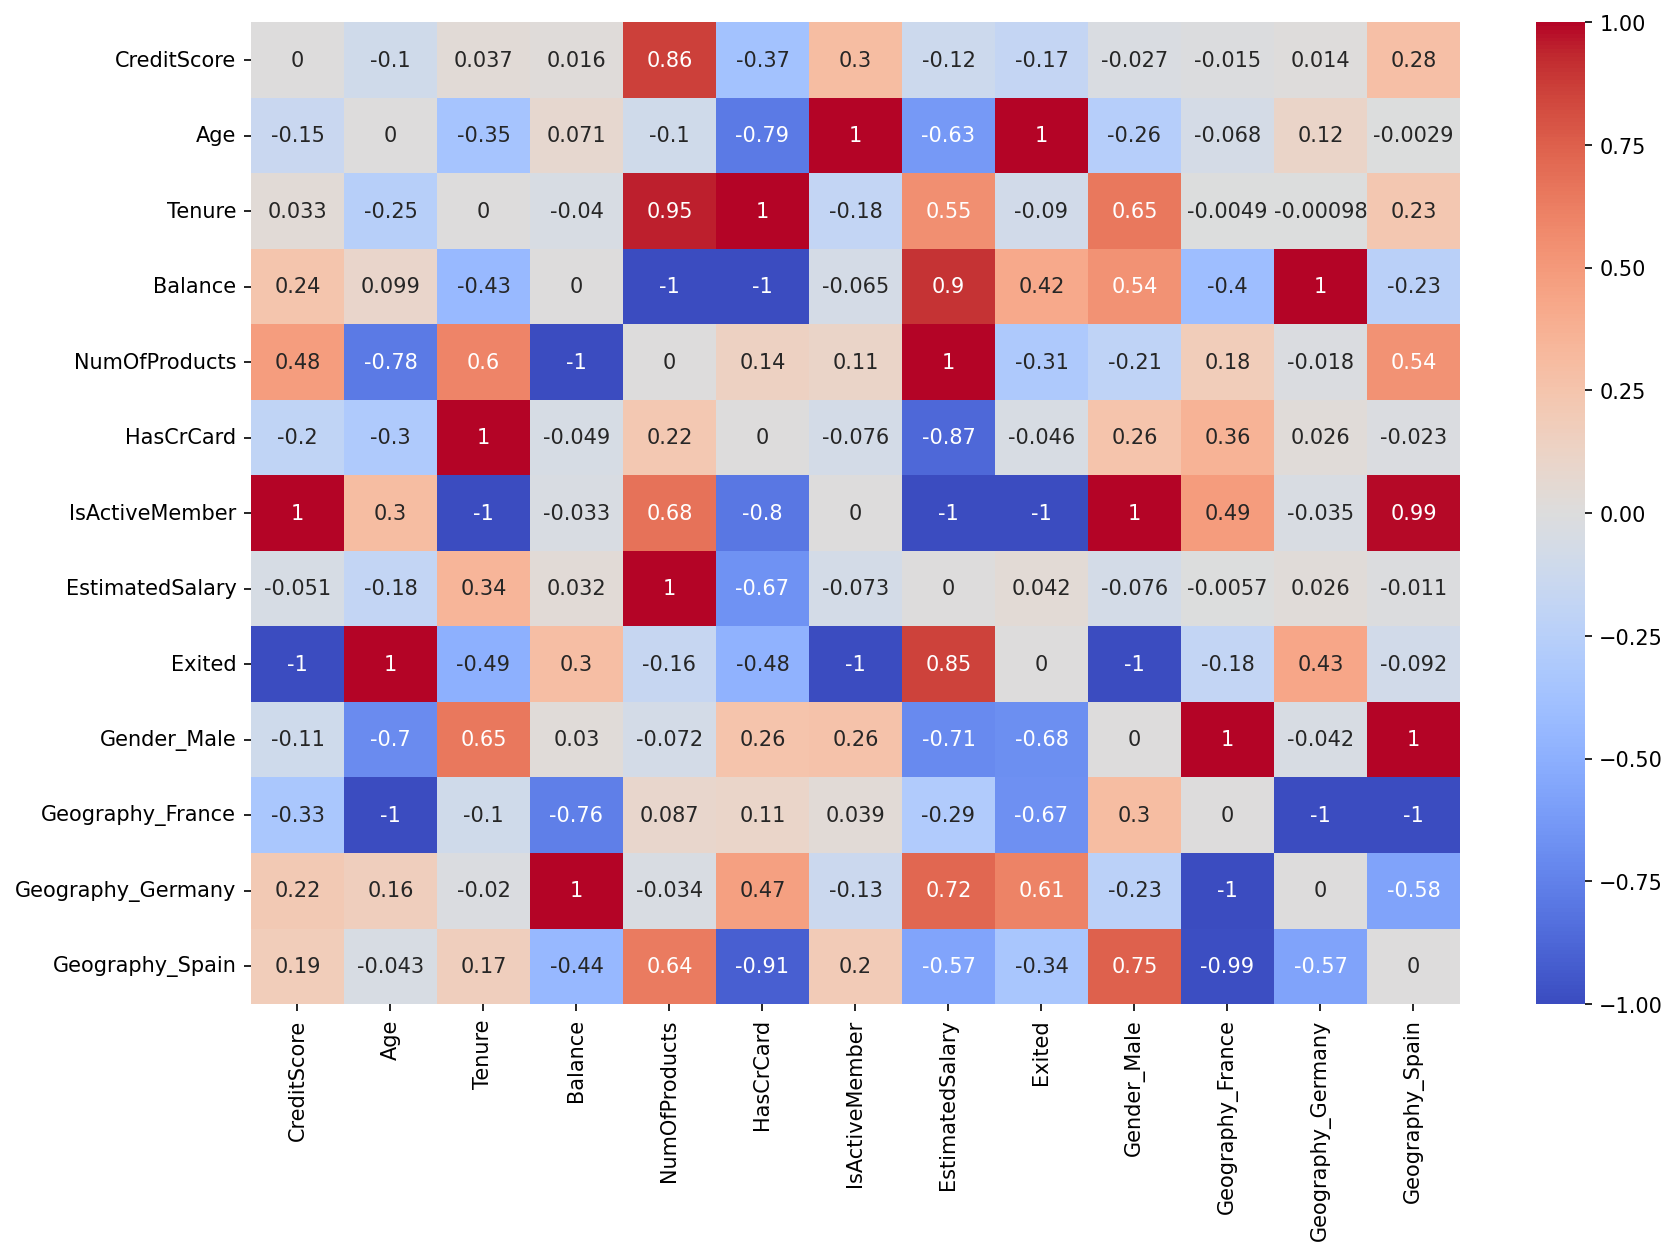

In [7]:
plt.figure(figsize=(13,8.5), dpi=150)

correlation = df.corr()
correlation[correlation==1] = 0

# Scale from -1 to 1
correlation[correlation<0] = -correlation[correlation<0]/correlation.min()
correlation[correlation>0] = correlation[correlation>0]/correlation.max()

sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)

Checking the "Exited" row in the correlation matrix, some conclusions can be drawn:

1. Credit score is negatively correlated with Exited, meaning that people with higher score are less likely to churn.
2. Older people tend to leave more.
3. People with more Tenure are also less likely to leave. But Tenure has low correlation with credit score.
4. Males tend to churn less and have more Tenure.
5. People with credit card are less likely to leave.
6. Non-active members leave more frequently.
7. The higher the estimated salary, the more likely to churn.
8. About geography, the churn is concentrated mostly in Germany.

##### 3.2. Showing main descriptive statistics

Based on the aforementioned conclusions, the main features related to churn are about 8 of the initial 12, these being the following:
- Credit Score
- Age
- Tenure
- Gender
- Has credit card
- Is an active member
- Estimated salary
- Geography

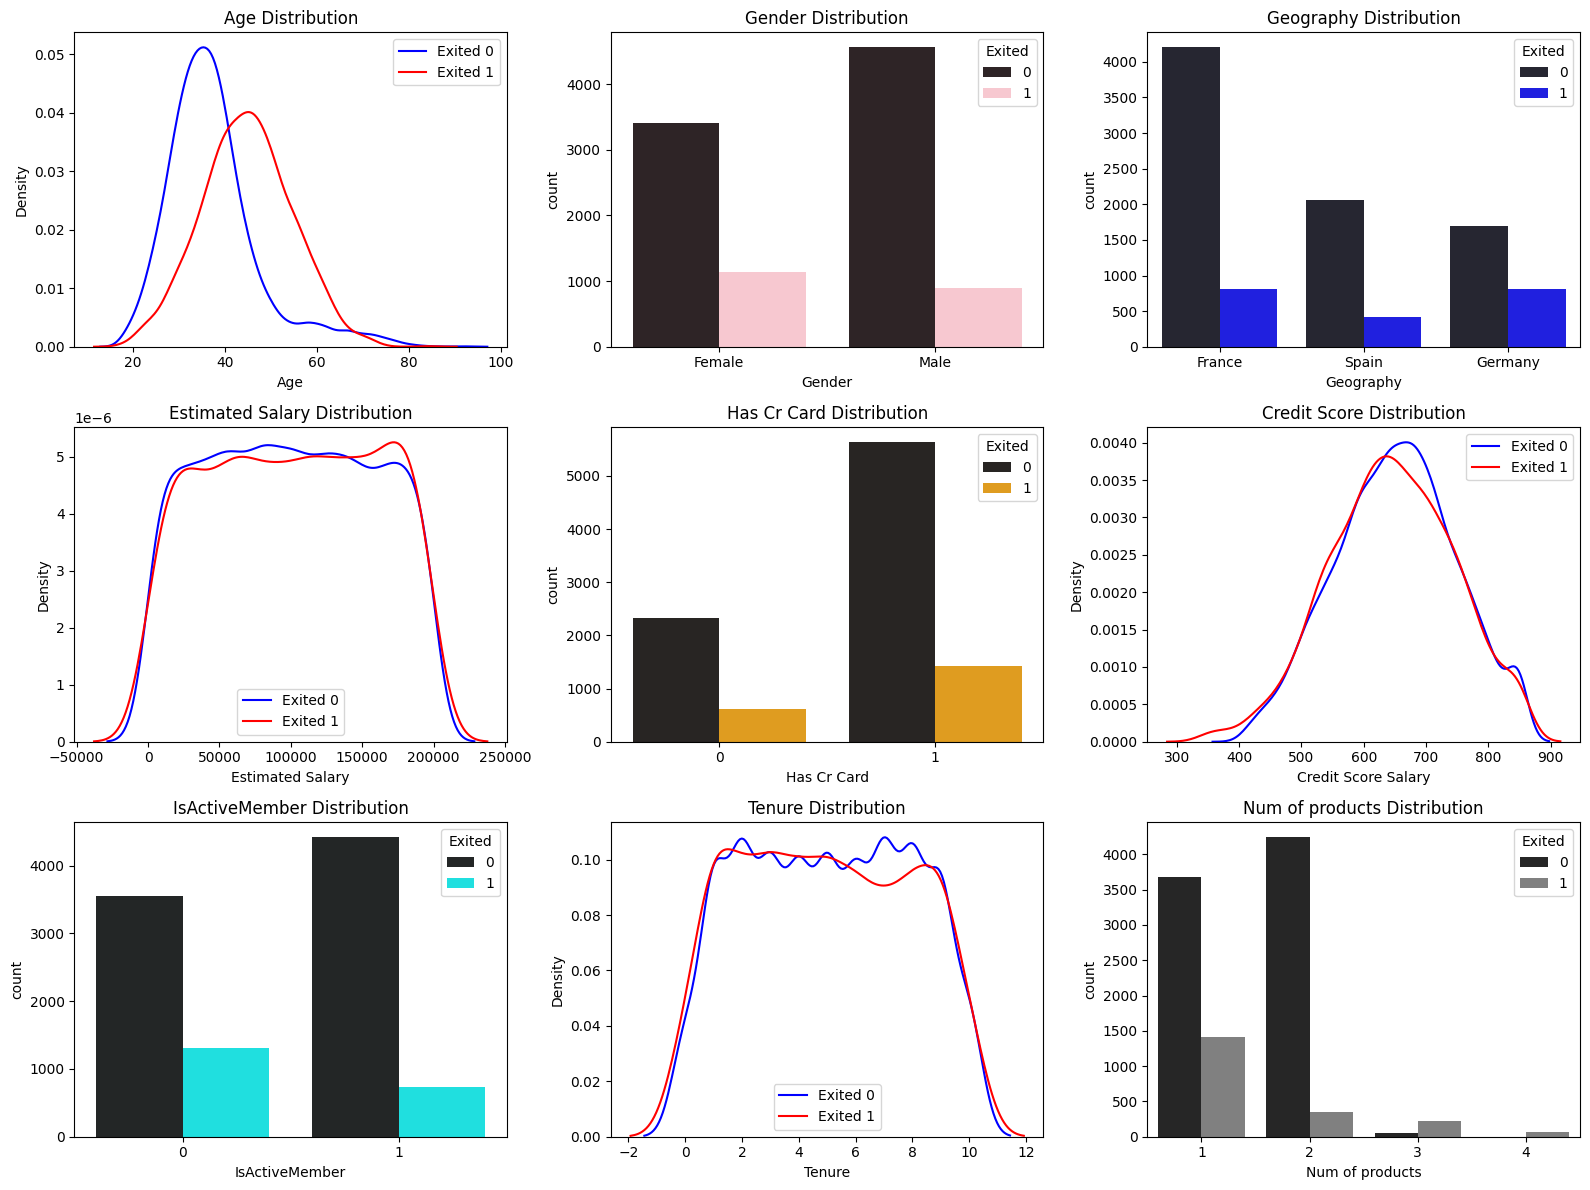

In [8]:
# Set the figure size and layout for horizontally stacked subplots
fig, axes = plt.subplots(3, 3, figsize=(16, 12), sharey=False)

# Age Distribution
sns.kdeplot(df_original['Age'][df_original['Exited'] == 0], color='blue', ax=axes[0,0])
sns.kdeplot(df_original['Age'][df_original['Exited'] == 1], color='red', ax=axes[0,0])
axes[0,0].set_title('Age Distribution')
axes[0,0].set_xlabel('Age')
axes[0,0].legend(['Exited 0', 'Exited 1'])

# Gender Distribution
sns.countplot(x='Gender', data=df_original, hue='Exited', ax=axes[0,1], palette='dark:pink')
axes[0,1].set_title('Gender Distribution')
axes[0,1].set_xlabel('Gender')

# Geography Distribution
sns.countplot(x='Geography', hue='Exited', data=df_original, ax=axes[0,2], palette='dark:blue')
axes[0,2].set_title('Geography Distribution')
axes[0,2].set_xlabel('Geography')


# Estimated Salary Distribution
sns.kdeplot(df_original['EstimatedSalary'][df_original['Exited'] == 0], color='blue', ax=axes[1,0])
sns.kdeplot(df_original['EstimatedSalary'][df_original['Exited'] == 1], color='red', ax=axes[1,0])
axes[1,0].set_title('Estimated Salary Distribution')
axes[1,0].set_xlabel('Estimated Salary')
axes[1,0].legend(['Exited 0', 'Exited 1'])

# How many have Cr Card
sns.countplot(x='HasCrCard', data=df_original, hue='Exited', ax=axes[1,1], palette='dark:orange')
axes[1,1].set_title('Has Cr Card Distribution')
axes[1,1].set_xlabel('Has Cr Card')

# Credit Score Distribution
sns.kdeplot(df_original['CreditScore'][df_original['Exited'] == 0], color='blue', ax=axes[1,2])
sns.kdeplot(df_original['CreditScore'][df_original['Exited'] == 1], color='red', ax=axes[1,2])
axes[1,2].set_title('Credit Score Distribution')
axes[1,2].set_xlabel('Credit Score Salary')
axes[1,2].legend(['Exited 0', 'Exited 1'])

# How many active
sns.countplot(x='IsActiveMember', data=df_original, hue='Exited', ax=axes[2,0], palette='dark:cyan')
axes[2,0].set_title('IsActiveMember Distribution')
axes[2,0].set_xlabel('IsActiveMember')

# Tenure
sns.kdeplot(df_original['Tenure'][df_original['Exited'] == 0], color='blue', ax=axes[2,1])
sns.kdeplot(df_original['Tenure'][df_original['Exited'] == 1], color='red', ax=axes[2,1])
axes[2,1].set_title('Tenure Distribution')
axes[2,1].set_xlabel('Tenure')
axes[2,1].legend(['Exited 0', 'Exited 1'])

# Num of products
sns.countplot(x='NumOfProducts', data=df_original, hue='Exited', ax=axes[2,2], palette='dark:gray')
axes[2,2].set_title('Num of products Distribution')
axes[2,2].set_xlabel('Num of products')


# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

Looking at the graphs above, the features that stand out the most are the *age, gender, geography, num of products,* and *if the member is active*. Other features have a slight difference.

For categorical variables, such as Gender, Geography, HasCrCard, and IsActiveMember, the graphs showed illustrate the frequency and proportion, which makes it easier to visualize the impact of the variable on the churn. The continuous variables (e.g., CreditScore, Age, Tenure, Balance, EstimatedSalary) graphs show the KDE (Kernel Density Estimation), which makes it straightforward to grasp the impact of the variables on the churn. In the KDE, it is easy to see the mean, median, mode, the spread (standard deviation), the skewness (to see the asymmetry), and the kurtosis (outliers).

About the most relevant features:
- For the **age**, the **churn** density is higher for people over 40 and below 70.
- Looking at the **gender**, female are more likely to **churn**.
- *Geography* shows that **churn** is more concentrated in *Germany*
- **Non-active members** **exited** more.
- The **Num of products** has high **churn** rate if the client has 3 or more products. For 2 products, lowest **churn** is found. And for 1, the **churn** rate is higher than for 2 products, but much lower than for 3 or 4 products. Therefore, someone having 3 or more products will likely indicate a possible churn candidate. This provides an insight about the bank's products. Maybe they have only 1 or 2 products that are worth it.

There are slight differences found in the *Estimated salary*, *Credit score*, and *Tenure* statistics:
- More **credit score** and **tenure**, slightly less **churn**.
- More **estimated salary**, a bit more **churn**.
These three statistics are purely financial.

Now, to see if these features have combined effect on the **churn**, it can be employed neural networks, for instance, to model these nonlinear relations. Then, after the model is trained, a sensitivity analysis can be performed, to assess how much a variable, and their combined effect, can affect the **churn**.